In [29]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_style("whitegrid")

# Comparing rich clubs between brain regions

In [30]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
networks = []
rc_comparison_df = pd.DataFrame(columns = ['genre', 'region_name', 'normalized_rc'])
for genre in genres:
    edge_list = pd.read_csv(f"../networks/{genre}_edge_list.csv").rename(columns={"Node1": "source", "Node2": "target"})
    node_list = pd.read_csv(f"../networks/{genre}_node_list.csv").rename(columns={"Node": "node_id"})

    network = nx.from_pandas_edgelist(edge_list, source='source', target='target')
    network.add_nodes_from([(dict(d)['node_id'], dict(d)) for _, d in node_list.iterrows()])

    network_rc_coef = pd.read_csv(f"./metrics/{genre}_dp_rc.csv")

    region_names = pd.read_csv("../visualization-data/region_names.csv")
    degrees = network.degree()

    node_list['region_name'] = ''
    for i, row in node_list.iterrows():
        # Add column to nodes that has more descriptive region names
        node_list.loc[i, 'region_name'] = region_names.loc[region_names['Region'] == row['Region'], 'region_name'].values[0]

    node_list['normalized_rc'] = 0.

    for n in network:
        k = degrees[n]
        node_list.loc[node_list['node_id'] == n, 'normalized_rc'] = np.mean(network_rc_coef.loc[network_rc_coef['degree'] == k, 'normalized_rc_coefficient'])

    node_list['genre'] = genre
    # region = node_list['region_name'].values
    # norm_rc = node_list['rc_coef'].values
    # new_rows = pd.DataFrame({'genre': genre, 'region': region, 'normalized_rc': norm_rc})
    rc_comparison_df = pd.concat([rc_comparison_df, node_list[['genre', 'region_name', 'normalized_rc']]], ignore_index=True)


/var/folders/d1/7zndxjcd2k53mp3zhx9lp0wm0000gn/T/ipykernel_27650/958124950.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rc_comparison_df = pd.concat([rc_comparison_df, node_list[['genre', 'region_name', 'normalized_rc']]], ignore_index=True)


In [31]:
rc_comparison_df = rc_comparison_df.loc[rc_comparison_df['normalized_rc'] != 0]

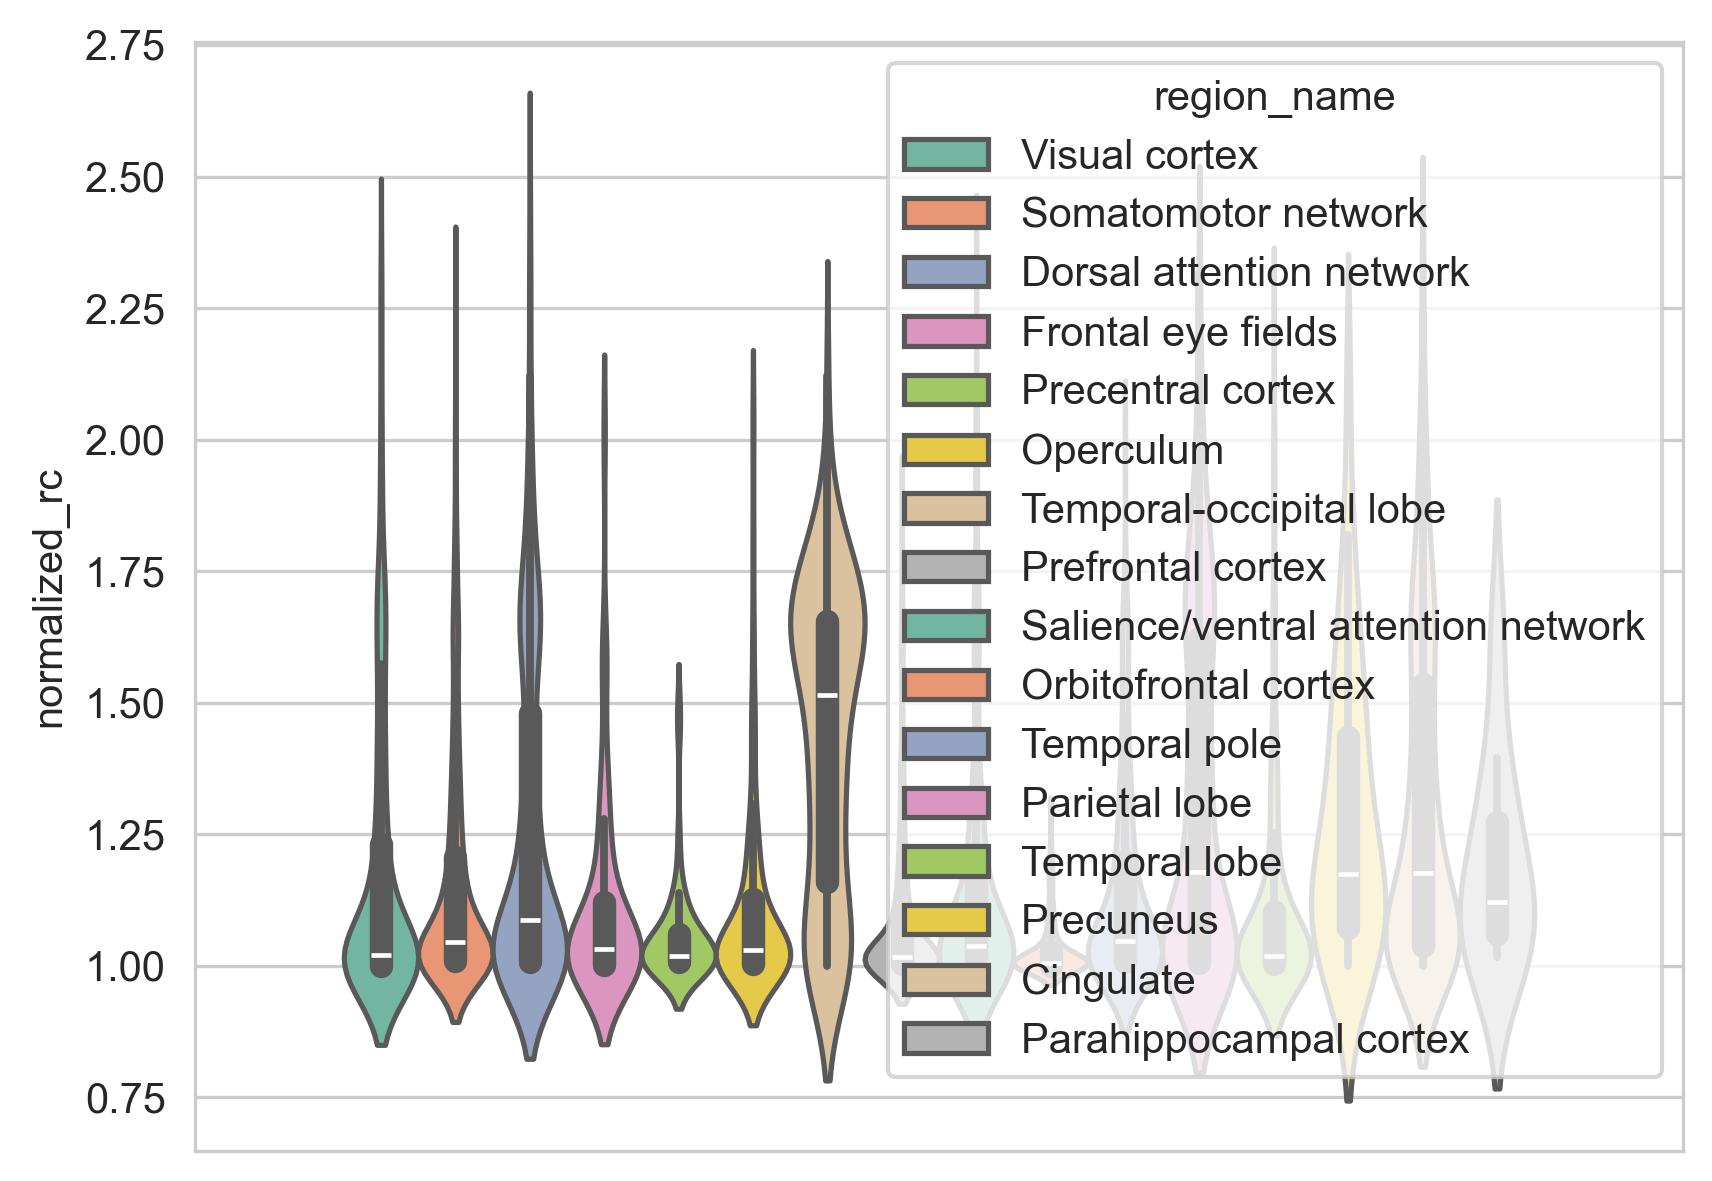

In [32]:
fig, ax = plt.subplots(dpi=300)
sns.violinplot(data=rc_comparison_df, y='normalized_rc', hue='region_name', palette='Set2')

plt.show()

In [33]:
mean_rc = rc_comparison_df.groupby('region_name')['normalized_rc'].mean()

In [34]:
top_3 = list(mean_rc.sort_values(ascending=False)[:3].index)
bottom_3 = list(mean_rc.sort_values()[:3].index)

In [35]:
top_3.extend(bottom_3)
vis_regions = rc_comparison_df.loc[rc_comparison_df['region_name'].isin(top_3)]

In [36]:
vis_regions

,genre,region_name,normalized_rc
118,blues,Precentral cortex,1.046920
119,blues,Precentral cortex,1.046920
120,blues,Precentral cortex,1.005251
127,blues,Temporal-occipital lobe,1.417624
139,blues,Prefrontal cortex,1.020021
...,...,...,...
5735,rock,Cingulate,1.535299
5736,rock,Cingulate,1.658665
5737,rock,Cingulate,1.303110
5738,rock,Cingulate,1.603922


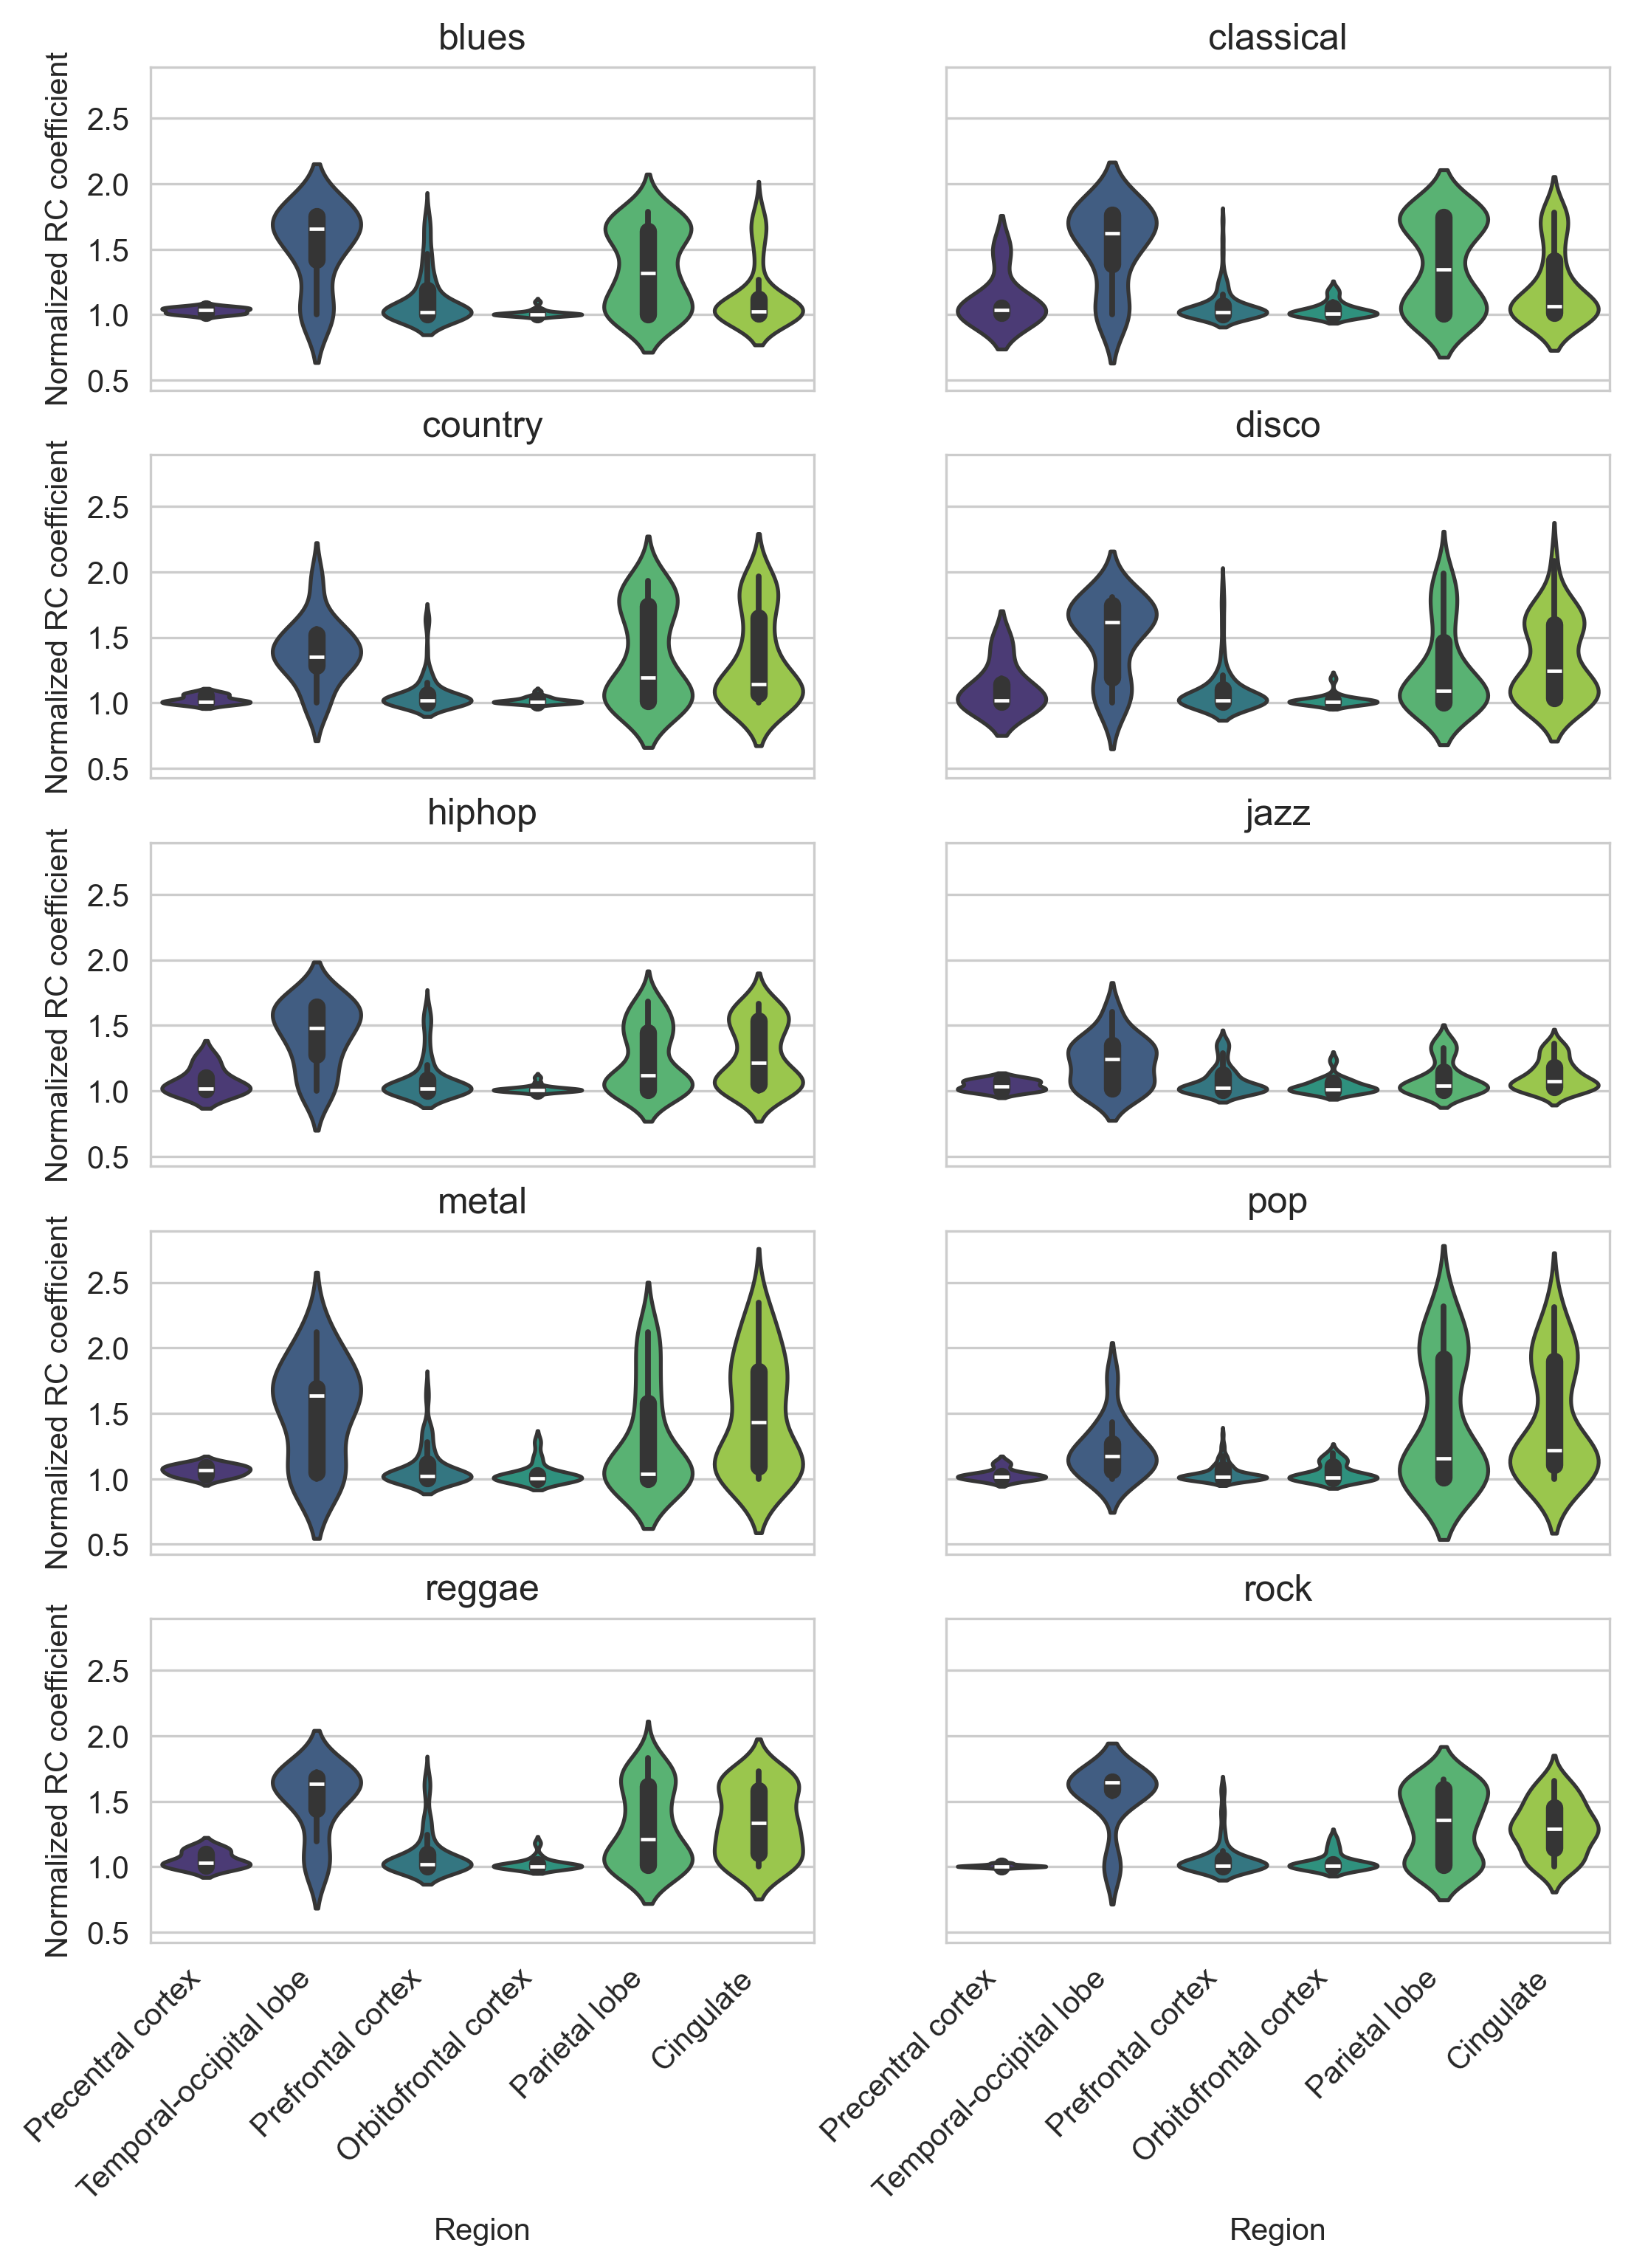

In [37]:
fig, axs = plt.subplots(dpi=300, nrows=5, ncols=2, figsize=(8.5, 11), sharex=True, sharey=True)

r = 0
for i in range(5):
    for j in range(2):
        genre = genres[r]
        subplot_data = vis_regions[vis_regions['genre'] == genre]
        sns.violinplot(data=subplot_data, y='normalized_rc', hue='region_name', x='region_name', palette=sns.color_palette('viridis', 6), ax=axs[i][j])
        axs[i][j].set(title=genre)
        r += 1
        if j == 0:
            axs[i][j].set_ylabel('Normalized RC coefficient')

axs[4][0].set_xticks(axs[4][0].get_xticks(), axs[4][0].get_xticklabels(), rotation=45, ha='right')
axs[4][1].set_xticks(axs[4][1].get_xticks(), axs[4][1].get_xticklabels(), rotation=45, ha='right')

axs[4][0].set(xlabel = 'Region')
axs[4][1].set(xlabel = 'Region')

fig.savefig('./plots/RC_region_distribution.png')
plt.show()